In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import thefuzz
import itertools
import numpy as np
import scipy

/home/carolisteia/miniconda3/envs/chartes/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/adata1_geocoded.csv', engine='python')


In [3]:
####################
#Nettoyage du texte 
####################

# Fonction de nettoyage du texte
def clean_text(texte):
    if isinstance(texte, str):
        # Supprimer les espaces blancs au début et à la fin du texte
        texte = texte.strip()
        # Convertir le texte en minuscules
        texte = texte.lower()
        # Remplacer les espaces multiples par un seul espace
        texte = ' '.join(texte.split())
        return texte
    return texte

# Appliquer la fonction de nettoyage à chaque colonne de type 'object', qui sont généralement des chaînes de caractères
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].apply(clean_text)

# Afficher le DataFrame nettoyé
df.head()


,cycle,genre,matter,work,witness,century_from,century_to,year_from,year_to,language,...,repository,localisation,latitude,longitude,call_number,author,obs.,philobiblon_id,digital_copy,transcription
0,cycle post-vulgate,romance de cavalaria,arthurienne,estoire del saint graal,liuro de josep abaramatia,13,14,1281,1325,portugais,...,arquivo distrital do porto,porto,41.143890,-8.616849,not/cns-ts01/001/0012,NaN,fragmento encontrado em 1992 por garcia guina ...,bitagap texid 1075/ cnum 21089,NaN,NaN
1,cycle post-vulgate,romance de cavalaria,arthurienne,estoire del saint graal,liuro de josep abaramatia intetulado a primeir...,16,16,1543,1543,portugais,...,arquivo nacional torre do tombo,lisbonne,38.754524,-9.156378,ms. 643 an/tt,NaN,(date colophon 1314). copia dedicada a d. joao...,bitagap texid 1075/cnum 1069,https://digitarq.arquivos.pt/details?id=4248673,NaN
2,cycle post-vulgate,romance de cavalaria,arthurienne,estoire del saint graal,libro de iosep abarimatia e otrosi libro del s...,15,15,1469,1470,castillan,...,biblioteca general histórica de la universidad...,salamanque,40.962660,-5.667900,ms 1877,NaN,traducido 1313 ca.,beta texid 2055 /cnum 2524,NaN,NaN
3,cycle post-vulgate,romance de cavalaria,arthurienne,queste-mort artu,historia dos caualleiros da mesa redonda e da ...,15,15,1425,1450,portugais,...,osterreichische nationalbibliothek,vienne,48.205376,16.365282,cod. 2594 han mag,NaN,NaN,bitagap texid 1070/ cnum 1811,https://digital.onb.ac.at/repviewer/viewer.fac...,https://cipm.fcsh.unl.pt/corpus/texto.jsp?t=d&...
4,cycle vulgate,romance de cavalaria,arthurienne,queste saint graal,la storia del sant grasal,14,14,1380,1380,catalan,...,biblioteca ambrosiana,milan,45.463621,9.186048,ms. i 79 sup.,guillem rexach traducteur,copia realizada por un mallorquin y no el orig...,biteca texid 1240/ cnum 340,NaN,NaN


In [4]:
####################
#work .unique
####################

# Récupérer les titres uniques et les trier
unique_titles = pd.unique(df['work']).astype(str)
sorted_titles = sorted(unique_titles)

# Afficher les titres uniques triés
print(sorted_titles)


['alexandreis', 'amadis', 'chanson de sebile', 'curial e güelfa', 'de la bonne enpereris qui garda loiaument sen mariage', 'el poema de mio cid', 'estoire del saint graal', 'florence de rome', "guillaume d'engleterre", 'historia apollonii regis tyri', 'lancelot', 'libro del caballero zifar', 'merlin', 'merlin (suite de merlin)', 'mocedades de rodrigo', 'mort artu', 'poema de fernán gonzález', 'queste saint graal', 'queste-mort artu', 'roncesvalles', 'tristan en prose', 'vie de saint eustace']


In [6]:
sorted_titles

['alexandreis',
 'amadis',
 'chanson de sebile',
 'curial e güelfa',
 'de la bonne enpereris qui garda loiaument sen mariage',
 'el poema de mio cid',
 'estoire del saint graal',
 'florence de rome',
 "guillaume d'engleterre",
 'historia apollonii regis tyri',
 'lancelot',
 'libro del caballero zifar',
 'merlin',
 'merlin (suite de merlin)',
 'mocedades de rodrigo',
 'mort artu',
 'poema de fernán gonzález',
 'queste saint graal',
 'queste-mort artu',
 'roncesvalles',
 'tristan en prose',
 'vie de saint eustace']

In [7]:
##########################################
#calculer et trier des similarités entre des paires de titres, selon la distance de Levenshtein
# avec la librairie thefuzz
###########################################

#exemple d'utilisation:
from thefuzz import fuzz
# Check the similarity score
ex1 = "Graal"
ex2 = "Grial"

print(f"Similarity score: {fuzz.partial_ratio(ex1, ex2)}")


Similarity score: 80


In [8]:
from itertools import combinations # utilisé pour créer toutes les combinaisons possibles de paires d'éléments dans un ensemble donné.

def generate_pairs(ensemble):
    return list(combinations(ensemble, 2))


In [9]:
for name1, name2 in generate_pairs(sorted_titles):
    print(name1, name2, fuzz.ratio(name1, name2))

alexandreis amadis 59
alexandreis chanson de sebile 36
alexandreis curial e güelfa 31
alexandreis de la bonne enpereris qui garda loiaument sen mariage 22
alexandreis el poema de mio cid 40
alexandreis estoire del saint graal 24
alexandreis florence de rome 44
alexandreis guillaume d'engleterre 30
alexandreis historia apollonii regis tyri 35
alexandreis lancelot 42
alexandreis libro del caballero zifar 28
alexandreis merlin 35
alexandreis merlin (suite de merlin) 29
alexandreis mocedades de rodrigo 32
alexandreis mort artu 20
alexandreis poema de fernán gonzález 29
alexandreis queste saint graal 28
alexandreis queste-mort artu 22
alexandreis roncesvalles 35
alexandreis tristan en prose 37
alexandreis vie de saint eustace 32
amadis chanson de sebile 26
amadis curial e güelfa 19
amadis de la bonne enpereris qui garda loiaument sen mariage 17
amadis el poema de mio cid 32
amadis estoire del saint graal 14
amadis florence de rome 9
amadis guillaume d'engleterre 21
amadis historia apollonii

In [10]:
# Initialisation d'une liste vide pour stocker les distances entre les paires de titres
distances = []

# Boucle sur toutes les paires possibles de titres générées par la fonction `generate_pairs`
for name1, name2 in generate_pairs(sorted_titles):
    # Calcul de la similarité entre les deux titres en utilisant la fonction `fuzz.ratio`
    distance = fuzz.ratio(name1, name2)
    
    # Création d'un tuple contenant les deux titres et leur distance calculée
    tupla_ = (name1, name2, distance)
    
    # Ajout du tuple à la liste des distances
    distances.append(tupla_)

# Définition d'une fonction qui renvoie la troisième valeur du tuple (la distance)
def get_third_value(tupla_):
    return tupla_[2]

# Tri de la liste des distances par ordre croissant en utilisant la troisième valeur (la distance)
# Puis on inverse la liste pour obtenir un ordre décroissant (du plus similaire au moins similaire)
distances = list(reversed(sorted(distances, key=get_third_value)))

# Affichage de la liste des distances triées
distances


[('estoire del saint graal', 'queste saint graal', 78),
 ('mort artu', 'queste-mort artu', 72),
 ('estoire del saint graal', 'vie de saint eustace', 60),
 ('alexandreis', 'amadis', 59),
 ('queste saint graal', 'vie de saint eustace', 53),
 ('queste saint graal', 'queste-mort artu', 53),
 ('florence de rome', 'tristan en prose', 50),
 ('florence de rome', 'mocedades de rodrigo', 50),
 ('el poema de mio cid', 'poema de fernán gonzález', 47),
 ('el poema de mio cid', 'merlin (suite de merlin)', 47),
 ('el poema de mio cid', 'mocedades de rodrigo', 46),
 ('el poema de mio cid', 'florence de rome', 46),
 ('mocedades de rodrigo', 'poema de fernán gonzález', 45),
 ('florence de rome', 'poema de fernán gonzález', 45),
 ('florence de rome', 'merlin (suite de merlin)', 45),
 ('curial e güelfa', 'tristan en prose', 45),
 ('chanson de sebile', 'estoire del saint graal', 45),
 ('tristan en prose', 'vie de saint eustace', 44),
 ('chanson de sebile', 'curial e güelfa', 44),
 ('alexandreis', 'florence

In [14]:
##############
#MATRICE
#############

In [11]:
# Calcul du nombre de titres dans la liste `sorted_titles`
n = len(sorted_titles)

# Création d'une matrice de taille n x n remplie de zéros à l'aide de NumPy
m = np.zeros((n, n))

# Création des index pour les colonnes et les lignes de la matrice
col_indexs = range(0, n)
row_indexs = range(0, n)

# Remplissage de la matrice avec les scores de similarité entre les titres
for row_index in row_indexs:
    for col_index in col_indexs:
        # Calcul de la similarité partielle entre les titres aux positions `row_index` et `col_index`
        # et assignation de la valeur correspondante à la position [row_index][col_index] dans la matrice `m`
        m[row_index][col_index] = fuzz.partial_ratio(sorted_titles[row_index], sorted_titles[col_index])

# Affichage de la matrice de similarité
m


array([[100.,  55.,  45.,  36.,  55.,  45.,  36.,  45.,  44.,  55.,  50.,
         45.,  44.,  40.,  50.,  25.,  42.,  36.,  27.,  50.,  45.,  45.],
       [ 55., 100.,  36.,  29.,  50.,  50.,  44.,  25.,  50.,  44.,  25.,
         33.,  36.,  36.,  50.,  33.,  50.,  44.,  33.,  36.,  40.,  33.],
       [ 45.,  36., 100.,  43.,  42.,  41.,  50.,  50.,  35.,  38.,  43.,
         47.,  36.,  47.,  47.,  24.,  43.,  38.,  25.,  50.,  48.,  45.],
       [ 36.,  29.,  43., 100.,  50.,  38.,  41.,  40.,  48.,  40.,  38.,
         47.,  40.,  47.,  37.,  29.,  40.,  33.,  29.,  40.,  47.,  42.],
       [ 55.,  50.,  42.,  50., 100.,  44.,  43.,  50.,  49.,  41.,  50.,
         40.,  50.,  50.,  45.,  44.,  41.,  51.,  44.,  35.,  50.,  50.],
       [ 45.,  50.,  41.,  38.,  44., 100.,  49.,  55.,  33.,  40.,  46.,
         47.,  50.,  49.,  51.,  38.,  64.,  31.,  33.,  35.,  45.,  44.],
       [ 36.,  44.,  50.,  41.,  43.,  49., 100.,  50.,  39.,  44.,  50.,
         53.,  50.,  46.,  41., 

In [12]:
########################
# cluster
#######################

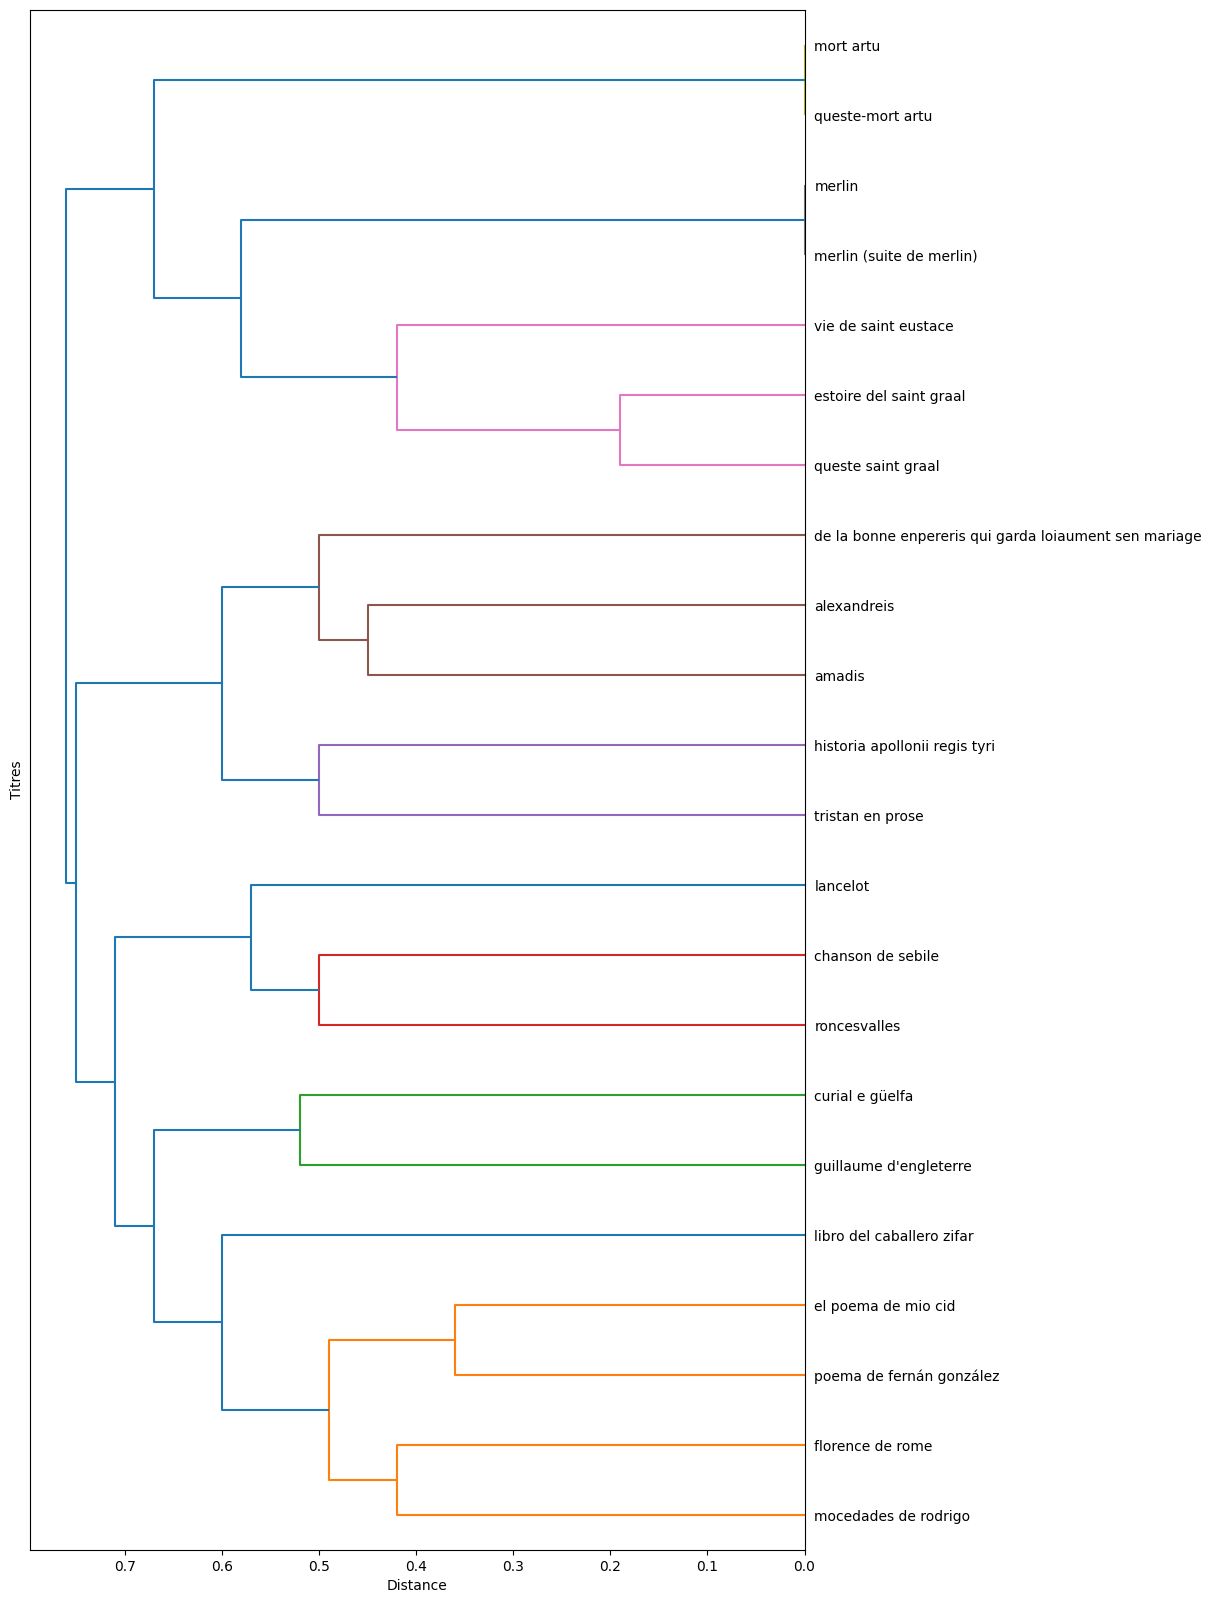

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convertir la similarité en distance
# La similarité est donnée en pourcentage (0-100), donc pour obtenir une distance,
# on la transforme en soustrayant chaque valeur de 1 (puis en divisant par 100).
distance_matrix = 1 - (m / 100)  # Ajuster correctement les similarités

# Convertir la matrice de distance en une matrice de distance condensée
# `squareform` est utilisé pour convertir la matrice carrée en une version condensée
# requise par la fonction de clustering hiérarchique
matrix_dist_cond = squareform(distance_matrix)

# Effectuer le clustering hiérarchique
# `linkage` applique le clustering hiérarchique à la matrice de distance condensée
# en utilisant la méthode 'complete' (distance maximale entre les clusters)
linked = linkage(matrix_dist_cond, method='complete')

# Tracer le dendrogramme pour visualiser le résultat du clustering
plt.figure(figsize=(10, 20))  # Définir la taille de la figure pour le dendrogramme
dendrogram(linked,
           orientation='left',  # L'orientation des branches du dendrogramme (horizontal pour chaque titre)
           labels=sorted_titles,  # Utiliser les titres triés comme étiquettes des feuilles du dendrogramme
           distance_sort='descending',  # Trier les distances de manière décroissante
           show_leaf_counts=True)  # Afficher le nombre de titres dans chaque cluster

# Ajouter des labels aux axes
#plt.title('Clustering hiérarchique des œuvres')  # (Optionnel) Titre du dendrogramme
plt.xlabel('Distance')  # Label pour l'axe des abscisses
plt.ylabel('Titres')  # Label pour l'axe des ordonnées

# Afficher le dendrogramme
plt.show()
